# Un'analisi IRT dei quesiti del Bebras italiano

L'*Item Response Theory* (IRT) è una tecnica statistica che si propone di stimare l'*abilità* dei soggetti cui viene sottoposto un test composto da una serie di domande (dette *item*). L'abilità è un tratto *latente*, cioè non osservabile direttamente: l'aver risposto correttamente a molte domande può dipendere sia da elevata abilità, che dalla "facilità" delle domande. La stima si basa quindi su un *modello matematico* (detto *Item Response Function*) della relazione fra abilità e probabilità di rispondere correttamente alla domanda.

Il modello usato in questa analisi è una curva *logistica*, la cui forma è regolata da tre parametri $a, b, c$.
$$ p_i(\theta_j) = c_i + \frac{(1 - c_i)}{1+ e^{-b_i\cdot(\theta_j - a_i)}} $$
La probabilità $p$ di successo in un *item* $i$ è funzione dell'abilità $\theta$ del solutore $j$. I tre parametri modellano le caratteristiche dell'*item*:
- $a$, detto *difficoltà* dell'item: determina il livello di abilità necessaria per avere il 50% di probabilità di successo;
- $b$, detto *differenziazione*: determina quanto influiscono le variazioni di abilità sulla probabilità di successo;
- $c$: fissa una probabilità minima di successo per qualsiasi abilità, dovuta per esempio alla possibilità di scegliere casualmente la risposta giusta ($c$ sarà 0 per un *item* a risposta completamente aperta)

In [1]:
logistic <- function(theta, a=0, b=1, c=0) { 
    c + (1-c)/(1 + exp(-b*(theta-a)))
}

In [132]:
data <- data.frame(x=seq(-5,5,.1));
data <- transform(data, 
                  y_mean = logistic(x), 
                  y_hard = logistic(x,a=2), 
                  y_easy=logistic(x,a=-2),
                  y_hdiscrimination=logistic(x,b=2),
                  y_ldiscrimination=logistic(x,b=.5)
                 );

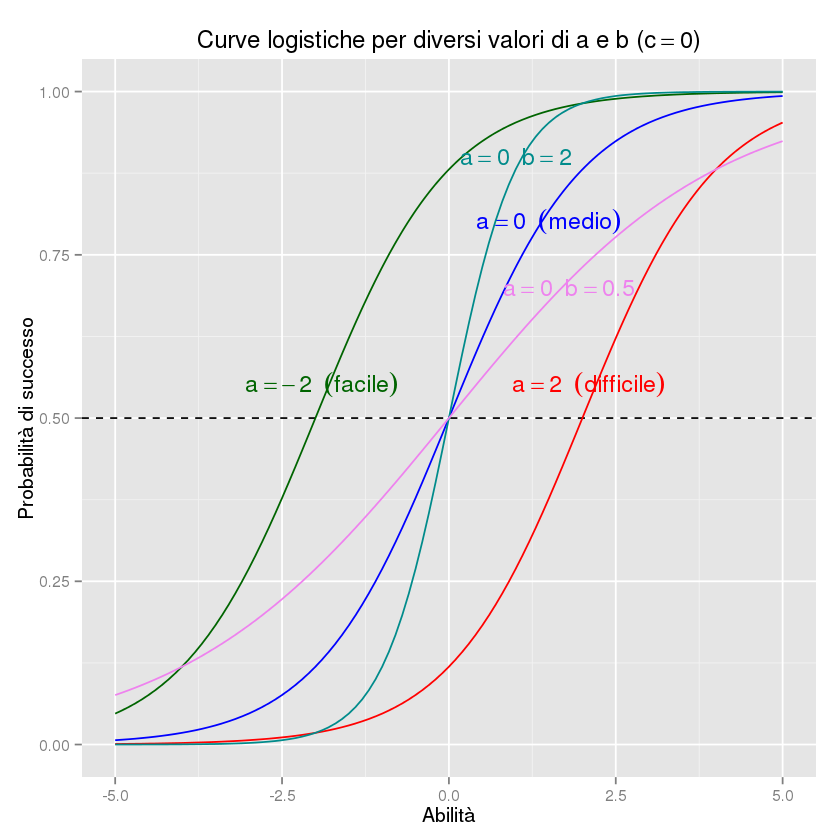

In [181]:
library("ggplot2")
p <- ggplot(data, aes(x=x));
p <- p + scale_x_continuous();
p <- p + geom_hline(yintercept=0.5, linetype="dashed");
p <- p + geom_line(aes(y=y_hard), color="red");
p <- p + annotate("text", x=2.1, y=.55, label="a == 2 ~~(plain(difficile))", parse=TRUE, color="red");
p <- p + geom_line(aes(y=y_easy), color="dark green");
p <- p + annotate("text", x=-1.9, y=.55, label="a == -2 ~~(plain(facile))", parse=TRUE, color="dark green");
p <- p + geom_line(aes(y=y_mean), color="blue");
p <- p + annotate("text", x=1.5, y=.8, label="a == 0 ~~(plain(medio))", parse=TRUE, color="blue");
p <- p + geom_line(aes(y=y_hdiscrimination), color="dark cyan");
p <- p + annotate("text", x=1, y=.9, label="a == 0 ~~ b == 2", parse=TRUE, color="dark cyan");
p <- p + geom_line(aes(y=y_ldiscrimination), color="violet");
p <- p + annotate("text", x=1.8, y=.7, label="a == 0 ~~ b == .5", parse=TRUE, color="violet");
p <- p + labs(title=expression(paste("Curve logistiche per diversi valori di ", a, " e ", b, " (",c==0,")")), 
              x="Abilità", y="Probabilità di successo")
p